In [183]:
import pandas as pd
import numpy as np

import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

import nltk
nltk.download('stopwords')
from nltk.stem.porter import PorterStemmer

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dovidb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Import Data

In [2]:
data = pd.read_csv("train.csv",usecols=["id","comment_text", "toxic"])

In [3]:
data.head()

,id,comment_text,toxic
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0


## Data Cleaning and Pre-Processing

In [4]:
data.toxic.value_counts()

0    144277
1     15294
Name: toxic, dtype: int64

In [5]:
# 10.6 percent of comments are toxic 
data[data["toxic"]==1].count()[1] / data[data["toxic"]==0].count()[1] *100

10.600442204925248

In [6]:
# create a new column with the length of the comment 
data['comment_length'] = data['comment_text'].str.len()

In [7]:
def number_of_upper(words):
    '''function to count the number of upper case letter in the comment'''
    return(sum(1 for c in words if c.isupper()))

In [8]:
# apply function to count number of uppercase letters in each comment 
data["number_uppercase"] = data['comment_text'].map(number_of_upper)

In [9]:
# create a new column that is the percent of words in the column that are upper case
data["percent_uppercase"] = data['number_uppercase'] / data['comment_length']

In [10]:
data.describe()

,toxic,comment_length,number_uppercase,percent_uppercase
count,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,394.073221,17.159628,0.051622
std,0.294379,590.720282,96.528103,0.092837
min,0.000000,6.000000,0.000000,0.000000
25%,0.000000,96.000000,3.000000,0.020710
50%,0.000000,205.000000,7.000000,0.031746
75%,0.000000,435.000000,15.000000,0.048830
max,1.000000,5000.000000,4960.000000,0.998189


## Examine percent toxic by percent uppercase

In [248]:
data[data.percent_uppercase<.2].toxic.mean()

0.0858824290241221

In [243]:
data[data.percent_uppercase<.2].toxic.count()

154630

In [239]:
data[(data.percent_uppercase<.45)&(data.percent_uppercase>=.20)].toxic.mean()

0.20387243735763097

In [249]:
data[(data.percent_uppercase<.45)&(data.percent_uppercase>=.20)].toxic.count()

2634

In [11]:
data[(data.percent_uppercase>=.45)].toxic.mean()

0.6402254009536195

In [12]:
data[(data.percent_uppercase>=.45)].toxic.count()

2307

Percent Uppercase Range | Count | Percent Toxic
--- | --- | ---
0 <= X < .2 | 154630 | 8.6%
0.2<=X< 0.45 | 2634 | 20.4%
X >=0.45 | 2307 | 64.0%


### Create Bins for Percent Uppercase

In [51]:
def bin_uppercase(df):
    '''Creates a function to turn Percent Uppercase into three binned groups'''
                        
    col="percent_uppercase"
    if df[col]   <0.2:
        return 2
    elif df[col] <0.45:
        return 4
    else:
        return 6

In [54]:
data["uppercase_binned"] = data.apply(bin_uppercase, axis=1)

In [55]:
data.groupby("uppercase_binned")["toxic"].mean()

uppercase_binned
2    0.085882
4    0.203872
6    0.640225
Name: toxic, dtype: float64

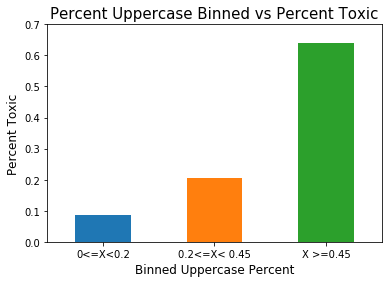

In [76]:
data.groupby("uppercase_binned")["toxic"].mean().plot(kind="bar")
plt.ylim(0,.7)
plt.title("Percent Uppercase Binned vs Percent Toxic",fontsize=15)
plt.ylabel("Percent Toxic",fontsize=12)
plt.xlabel("Binned Uppercase Percent",fontsize=12)
plt.xticks([0,1,2],["0<=X<0.2","0.2<=X< 0.45", "X >=0.45"],rotation=0)
plt.show()

## Examine percent toxic by comment length

In [36]:
data[data.comment_length<110].toxic.mean()

0.1520612946758957

In [38]:
data[data.comment_length<110].toxic.count()

45942

In [45]:
data[(data.comment_length>=110)&(data.comment_length<300)].toxic.mean()

0.08897764160922056

In [47]:
data[(data.comment_length>=110)&(data.comment_length<300)].toxic.count()

54834

In [46]:
data[(data.comment_length>=300)&(data.comment_length<2500)].toxic.mean()

0.05623961255964401

In [48]:
data[(data.comment_length>=300)&(data.comment_length<2500)].toxic.count()

55957

In [49]:
data[data.comment_length>=2500].toxic.mean()

0.09936575052854123

In [50]:
data[data.comment_length>=2500].toxic.count()

2838

Comment Length Range | Count | Percent Toxic
--- | --- | ---
0 <= X  < 110 | 45942 | 15.2%
110 <=X< 300 | 54834 | 8.9%
300 <=X< 2500 | 55957 | 5.6%
X >=2500 | 2838 | 9.9%

### Create Bins for Comment Length

In [59]:
def bin_length(df):
    '''Creates a function to turn Percent Uppercase into three binned groups'''
                        
    col="comment_length"
    if df[col]   <110:
        return 110
    elif df[col] <300:
        return 300
    elif df[col] <2500:
        return 1000
    else:
        return 2500

In [60]:
data["lenth_binned"] = data.apply(bin_length, axis=1)

In [61]:
# Confirm above worked. 
data.groupby("lenth_binned")["toxic"].mean()

lenth_binned
110     0.152061
300     0.088978
1000    0.056240
2500    0.099366
Name: toxic, dtype: float64

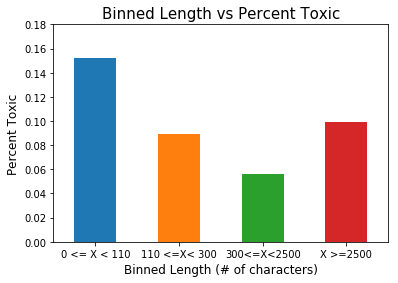

In [86]:
data.groupby("lenth_binned")["toxic"].mean().plot(kind="bar")
plt.ylim(0,.18)
plt.title("Binned Length vs Percent Toxic",fontsize=15)
plt.ylabel("Percent Toxic",fontsize=12)
plt.xlabel("Binned Length (# of characters)",fontsize=12)
plt.xticks([0,1,2,3],["0 <= X < 110","110 <=X< 300", "300<=X<2500", "X >=2500"],rotation=0)
plt.show()

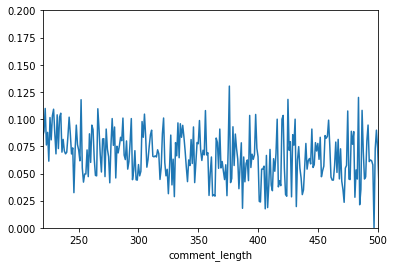

In [41]:
data.groupby("comment_length")['toxic'].mean().plot()
plt.xlim(220,500)
plt.ylim(0,.2)
plt.show()

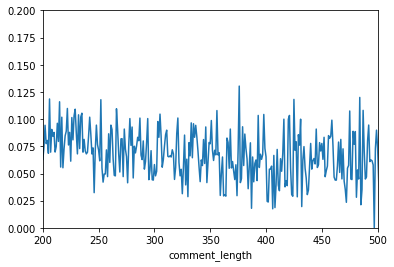

In [27]:
data.groupby("comment_length")['toxic'].mean().plot()
plt.xlim(200,500)
plt.ylim(0,.2)
plt.show()

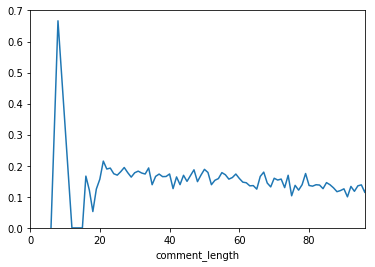

In [25]:
data.groupby("comment_length")['toxic'].mean().plot()
plt.xlim(0,96)
plt.ylim(0,.7)
plt.show()

## Statistical Analysis of binned features

In [62]:
from scipy.stats import chi2_contingency

In [63]:
def chi_cont_func(col1,col2):
    a=data[data[col1]==0].groupby(col2)[[col1]].count()
    b= data[data[col1]==1].groupby(col2)[[col1]].count()
    data_array= np.concatenate((a.values.T,b.values.T),axis=0)
    return chi2_contingency(data_array)

In [64]:
chi_cont_func('toxic', 'lenth_binned')

(2718.536457453545,
 0.0,
 3,
 array([[41538.71276109, 49578.46361808, 50593.83026364,  2565.99335719],
        [ 4403.28723891,  5255.53638192,  5363.16973636,   272.00664281]]))

In [65]:
chi_cont_func('toxic', 'uppercase_binned')

(8421.18294291103,
 0.0,
 2,
 array([[139809.5675906 ,   2381.54563173,   2085.88677767],
        [ 14820.4324094 ,    252.45436827,    221.11322233]]))

#### Running a Chi-Squared test for statistical independence for the binned uppercase and length variables results in a p-value of zero. This implies that both variables are statically significant in predicting whether a topic is toxic or benign. 

## Process Binned data for Machine Learning

In [167]:
# isolate the extra created columns 
extra_data1 = data[["uppercase_binned","lenth_binned"]].astype(str)

# Use the get dummies function to turn these variables into boolian for machine learning analysis. 
extra_data = pd.get_dummies(extra_data1, drop_first=True).values

## Process text data 

In [87]:
# Create a new column to work on the text
data['clean_text'] = data['comment_text']

In [88]:
# remove new line, make lower case, remove apostrophe 

def remove_new_line(mystring):
    mystring = mystring.replace("\n", " ") #  removes the new line characters 
    mystring = mystring.lower()            # turns the whole string to lower case letters 
    mystring = mystring.replace("'", "")   # removes appostrophes 
    return(mystring)

In [90]:
# create regex that will allow for grabing only the words in the comments
prog = re.compile("[a-z]+")
#result = prog.findall(test_s_2)

In [91]:
def grab_words(words):
    '''grabs only the words from the comments and returns them in a string'''
    return(' '.join(prog.findall(words)))

In [92]:
def remove_stop_words(word_list):
    new_words = []
    for word in word_list:
        if not word in stopwords.words('english'):
            new_words.append(word)
    return(new_words)

### Run data pre-processing

In [93]:
data["clean_text"] = data["clean_text"].map(remove_new_line)

In [94]:
data["clean_text"] = data["clean_text"].map(grab_words)

In [95]:
# run the cleaned data through a vectorizer which also removes the english stopwords 
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(data.clean_text)
X = X.tocsc()
y = np.array(data.toxic , dtype=int)

In [97]:
# Split the data for training and testing  
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [98]:
# reshape for ml to work 
y_train = np.array(Y_train, dtype=int)
y_test = np.array(Y_test, dtype=int)

## Run Naive Bayes Classifier 

In [99]:
# create an instance of the Naive Bayes classifier 
mNB = MultinomialNB()
# fit the training data. 
mNB.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [100]:
mNB.score(X_train, y_train)

0.9568136241148085

In [101]:
#  Accruacy score for the test set  
mNB.score(X_test, y_test)

0.9411875293749021

In [102]:
metrics.roc_auc_score(y_test,mNB.predict_proba(X_test)[:,1])

0.8977721716201302

In [103]:
print(metrics.f1_score(y_test, mNB.predict(X_test)))

0.6720251616285164


In [104]:
# We see how the f1-score and the accuracy of the algorithm change with different thresholds. 
thresh_list = np.arange(0.45,0.60,0.01)  
mNB_proba = mNB.predict_proba(X_test)[:,1]
print("Threshold---f1-score---accuracy")
for value in thresh_list:
    prediction = mNB_proba > value
    f1_score_v = metrics.f1_score(y_test,prediction)
    total_score = metrics.accuracy_score(y_test,prediction)
    print(value , f1_score_v, total_score )

Threshold---f1-score---accuracy
0.45 0.6707946336429308 0.9400281999060003
0.46 0.6720745598895409 0.9404668651104496
0.47000000000000003 0.6715176715176715 0.9405921980260066
0.48000000000000004 0.6718777140871982 0.9408115306282312
0.49000000000000005 0.6713140467061693 0.940905530314899
0.5 0.6720251616285164 0.9411875293749021
0.51 0.6732083406343087 0.941563528121573
0.52 0.6735769501054111 0.9417828607237976
0.53 0.6735915492957747 0.9419081936393545
0.54 0.6719632768361582 0.9417828607237976
0.55 0.6713906111603188 0.9418768604104653
0.56 0.6714057224098098 0.9420648597838007
0.5700000000000001 0.6709493219129193 0.9422215259282469
0.5800000000000001 0.6714387974230493 0.9424721917593608
0.5900000000000001 0.6716899892357374 0.9426601911326963


#### Applying a threshold of greater than 0.53 gives the greatest F1-score of 0.674

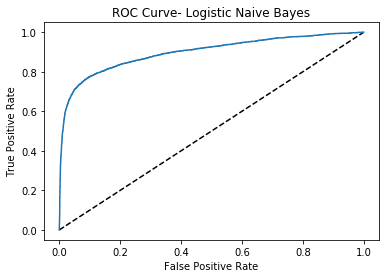

In [105]:
# ROC CURVE 

y_pred_prob = mNB.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve- Logistic Naive Bayes')
plt.show()

### Run a Stemmer on the words 

In [172]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english", ignore_stopwords=True)

In [201]:
analyzer = CountVectorizer(stop_words='english', min_df = 20, max_df= 0.8).build_analyzer()
    # try out min_df =20 , max_df = 0.8 . Doing this brings the elements stored from 3802330 to 3516476 

def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

stem_vectorizer = CountVectorizer(analyzer=stemmed_words, min_df = 20, max_df= 0.8)

In [202]:
# apply the stemmer and count vectorizer to the data 
X_stem = stem_vectorizer.fit_transform(data.clean_text)
X_stem = X_stem.tocsc()

 Before the min_df and max_df: 159571x133048 sparse matrix of type '<class 'numpy.int64'
	with 3802330 stored elements in Compressed Sparse Column format

 # Find optimal min_df - 
 ## memory error below did not run 

In [204]:
# x_plot = X_stem.toarray()

# df =  pd.DataFrame(x_plot)
# # replace the zeros with nan so we can count document frequency per word. 
# df_2 = df.replace(0, np.NaN)

# # count the document frequency for each word. Then turn count into a dataframe. 
# df_3 = df_2.count(axis=0).to_frame()
# df_3.columns = ['word_count']

# # get a value counts on this number to get # of docs for each word
# df_3 = df_3["word_count"].value_counts().to_frame().reset_index()  
# df_3.columns = ['number_times','word_count']

# # we sort and then get the cumulative sum of the counts
# df_4 = df_3.sort_values(by='number_times')
# df_4['sum'] = df_4["word_count"].cumsum()


In [205]:
# Split the data for training and testing  
X_train_stem, X_test_stem, Y_train_stem, Y_test_stem = train_test_split(X_stem, y, test_size=0.2, random_state=42)

In [206]:
# reshape for ml to work 
y_train_stem = np.array(Y_train_stem, dtype=int)
y_test_stem = np.array(Y_test_stem, dtype=int)

In [207]:
# create an instance of the Naive Bayes classifier 
mNB_stem = MultinomialNB()
# fit the training data. 
mNB_stem.fit(X_train_stem , y_train_stem)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [208]:
mNB_stem.score(X_train_stem , y_train_stem)

0.9500924359215391

In [209]:
mNB_stem.score(X_test_stem , y_test_stem)

0.9490208365972114

In [210]:
metrics.roc_auc_score(y_test_stem,mNB_stem.predict_proba(X_test_stem)[:,1])

0.9305576147994519

In [211]:
print(metrics.f1_score(y_test_stem, mNB_stem.predict(X_test_stem)))

0.7353180413209695


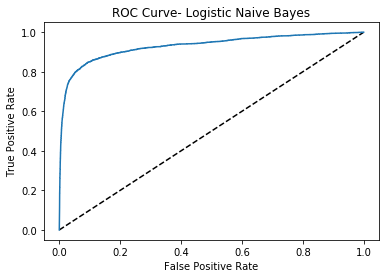

In [212]:
# ROC CURVE 

y_pred_prob = mNB_stem.predict_proba(X_test_stem)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test_stem, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve- Logistic Naive Bayes')
plt.show()

## Apply Grid Search to find optimal Alpha parameter. 

In [213]:
MNB_grid = MultinomialNB()
param_grid = {"alpha": [.1, 1, 5, 10, 50]}

CV_MNB = GridSearchCV(estimator=MNB_grid, param_grid=param_grid, cv= 3, scoring= "f1" , n_jobs=-1)
CV_MNB.fit(X_train_stem, y_train_stem)
print (CV_MNB.best_params_)

{'alpha': 1}


### A grid seach shows that an alpha value of 1 is optimal for our data set. 

# try TF-IDF 

In [203]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train)


In [204]:
# create an instance of the Naive Bayes classifier 
mNB_tf = MultinomialNB()
# fit the training data. 
mNB_tf.fit(X_train_tfidf, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [205]:
mNB_tf.score(X_train, y_train)

0.9349188443943097

In [206]:
mNB_tf.score(X_test, y_test)

0.9308162306125646

In [207]:
metrics.roc_auc_score(y_test,mNB_tf.predict_proba(X_test)[:,1])

0.8131802799456974

In [208]:
print(metrics.f1_score(y_test, mNB_tf.predict(X_test)))

0.45156482861400893


## Ran TF-IDF, this made the model worse. 

# Random Forest Classifier 

In [121]:
rfc = RandomForestClassifier(n_jobs=-1, random_state = 42)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [122]:
training_accuracy = rfc.score(X_train, y_train)
test_accuracy = rfc.score(X_test, y_test)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Accuracy on training data: 0.994838
Accuracy on test data:     0.949272


In [123]:
metrics.roc_auc_score(y_test,rfc.predict_proba(X_test)[:,1])

0.9349407692918937

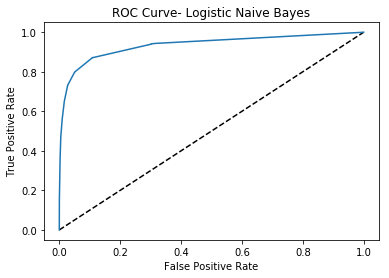

In [124]:
# ROC CURVE 

y_pred_prob_rf = rfc.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_rf)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve- Logistic Naive Bayes')
plt.show()

In [125]:
print(metrics.f1_score(y_test, rfc.predict(X_test)))

0.6790882061446978


# Random Forest Classifier -- Stemmed Data 

In [177]:
rfc = RandomForestClassifier(n_jobs=-1, random_state = 42)
rfc.fit(X_train_stem, y_train_stem)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [179]:
training_accuracy = rfc.score(X_train_stem, y_train_stem)
test_accuracy = rfc.score(X_test_stem, y_test_stem)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Accuracy on training data: 0.994752
Accuracy on test data:     0.950086


In [180]:
metrics.roc_auc_score(y_test_stem,rfc.predict_proba(X_test_stem)[:,1])

0.9398764726548235

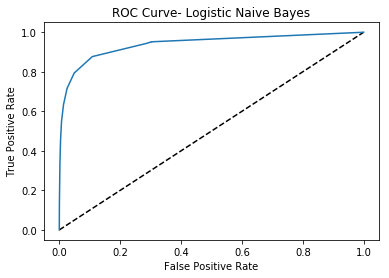

In [181]:
# ROC CURVE 

y_pred_prob_rf = rfc.predict_proba(X_test_stem)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test_stem, y_pred_prob_rf)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve- Logistic Naive Bayes')
plt.show()

In [188]:
print(metrics.f1_score(y_test_stem, rfc.predict(X_test_stem)))

0.6774650739015994


### Grid Search for Random Forest Hyperparameters 

In [184]:
rfc_grid = RandomForestClassifier(n_jobs=-1, random_state = 42)
param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}
CV_rfc = GridSearchCV(estimator=rfc_grid, param_grid=param_grid, cv= 3, scoring= "f1" , n_jobs=-1)
CV_rfc.fit(X_train_stem, y_train_stem)
print (CV_rfc.best_params_)

{'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 10, 'min_samples_leaf': 1, 'min_samples_split': 10}


{'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 10, 'min_samples_leaf': 1, 'min_samples_split': 10}

### Check on above grid search results

In [185]:
rfc_gs = RandomForestClassifier(n_jobs=-1, random_state = 42, bootstrap= False, criterion = 'entropy', max_features=10,min_samples_split=10)
rfc_gs.fit(X_train_stem, y_train_stem)

RandomForestClassifier(bootstrap=False, class_weight=None,
            criterion='entropy', max_depth=None, max_features=10,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

In [186]:
training_accuracy = rfc_gs.score(X_train_stem, y_train_stem)
test_accuracy = rfc_gs.score(X_test_stem, y_test_stem)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Accuracy on training data: 0.997094
Accuracy on test data:     0.937302


In [187]:
metrics.roc_auc_score(y_test_stem,rfc_gs.predict_proba(X_test_stem)[:,1])

0.9365038620253121

In [189]:
print(metrics.f1_score(y_test_stem, rfc_gs.predict(X_test_stem)))

0.5328978068128792


### Grid Search for Random Forest Hyperparameters - 2nd try 

Keep from the last grid search:  bootstrap= False, criterion = 'entropy'.

In [190]:
rfc_grid2 = RandomForestClassifier(n_jobs=-1, random_state = 42,bootstrap= False, criterion = 'entropy' )
param_grid2 = {
              "max_features": [ 10,'auto' ],
              "min_samples_split": [2, 10, 15],
              "min_samples_leaf": [1, 10, 15] }
CV_rfc2 = GridSearchCV(estimator=rfc_grid2, param_grid=param_grid2, cv= 3, scoring= "f1" , n_jobs=-1)
CV_rfc2.fit(X_train_stem, y_train_stem)
print (CV_rfc2.best_params_)

{'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 10}


results: {'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 10} same as defaults execpt for min_samples_split

#### Test of above

In [191]:
rfc_gs2 = RandomForestClassifier(n_jobs=-1, random_state = 42, bootstrap= False, criterion = 'entropy', max_features='auto',min_samples_split=10)
rfc_gs2.fit(X_train_stem, y_train_stem)

RandomForestClassifier(bootstrap=False, class_weight=None,
            criterion='entropy', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

In [194]:
training_accuracy = rfc_gs2.score(X_train_stem, y_train_stem)
test_accuracy = rfc_gs2.score(X_test_stem, y_test_stem)
auc =  metrics.roc_auc_score(y_test_stem,rfc_gs2.predict_proba(X_test_stem)[:,1])
f1score = metrics.f1_score(y_test_stem, rfc_gs2.predict(X_test_stem))

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))
print("AUC on test data:          {:2f}".format(auc))
print("F1 Score on test data:     {:2f}".format(f1score))

Accuracy on training data: 0.997485
Accuracy on test data:     0.950149
AUC on test data:          0.953450
F1 Score on test data:     0.674842


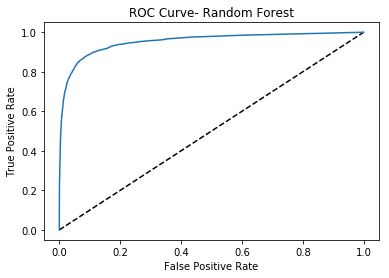

In [195]:
# ROC CURVE 

y_pred_prob_rf = rfc_gs2.predict_proba(X_test_stem)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test_stem, y_pred_prob_rf)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve- Random Forest')
plt.show()

### Grid Search for Random Forest Hyperparameters - 3rd try 

### Most Important Features using Random Forest

In [146]:
important_feature = pd.DataFrame(rfc.feature_importances_, index = np.array(vectorizer.get_feature_names()), columns =['importance']).sort_values('importance',ascending=False)

In [148]:
important_feature[:20]

,importance
fuck,0.042238
shit,0.024147
fucking,0.024142
bitch,0.019771
suck,0.014190
ass,0.013264
stupid,0.011506
asshole,0.010994
faggot,0.009861
idiot,0.009759


## Find strong predictive words - does not work 
###  memory error below did not run 

In [114]:
X_test.shape[1]

173828

In [111]:
words = np.array(vectorizer.get_feature_names())
ii = np.eye(X_test.shape[1])
probs = mNB.predict_log_proba(ii)[:,0]
ind = np.argsort(probs)

good_words = words[ind[:10]]
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

MemoryError: 